In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler


Part 1: Get the data
We used Yahoo Finance to get the data for Tesal stock from 2017/1/6 to 2022/1/5. Our analysis is daily-based, and all the decisions are made using the open price on each day.

For a reason which will be clarified by the following code, our analysis will start from 50 days after January 6, 2017 and end the day before January 5, 2022.

We used Yahoo Finance and DataReader to obtain and load trading data for Tesla stock.

In [2]:
# Identify stock data to grab by ticker
ticker = 'TSLA'

start_date=datetime.datetime(2017,1,6)
end_date=datetime.datetime(2022,1,5)

# df=pd.read_csv("TSLA-2.csv")
# df.index=pd.to_datetime(df["Date"])
# df=df.drop("Date",axis=1)

In [3]:
# For reading stock data from yahoo
from pandas_datareader.data import DataReader

df = DataReader(ticker, 'yahoo', start_date, end_date)

df.drop("Adj Close",axis=1,inplace=True) # May have to adjut columns later

Now for each day we have the closing price for the day, the closing price of the previous day and the open price of the following day.

The feature rapp is the quotient between the previous day's close and today's closing price. It will be used because it gives the variation (return) of the portfolio for the day.

In [4]:
df['Prev_Close']=df['Close'].shift(1)
df.head()

,High,Low,Open,Close,Volume,Prev_Close
Date,,,,,,
2017-01-06,46.062000,45.090000,45.386002,45.801998,27639500.0,NaN
2017-01-09,46.383999,45.599998,45.793999,46.256001,19897500.0,45.801998
2017-01-10,46.400002,45.377998,46.400002,45.973999,18300000.0,46.256001
2017-01-11,45.995998,45.335999,45.813999,45.945999,18254000.0,45.973999
2017-01-12,46.139999,45.116001,45.812000,45.917999,18951000.0,45.945999


In [5]:
df["rapp"]=df["Close"].divide(df['Close'].shift(1)) # Should be the close of the previous close

In [6]:
df.head(10)

,High,Low,Open,Close,Volume,Prev_Close,rapp
Date,,,,,,,
2017-01-06,46.062000,45.090000,45.386002,45.801998,27639500.0,NaN,NaN
2017-01-09,46.383999,45.599998,45.793999,46.256001,19897500.0,45.801998,1.009912
2017-01-10,46.400002,45.377998,46.400002,45.973999,18300000.0,46.256001,0.993903
2017-01-11,45.995998,45.335999,45.813999,45.945999,18254000.0,45.973999,0.999391
2017-01-12,46.139999,45.116001,45.812000,45.917999,18951000.0,45.945999,0.999391
2017-01-13,47.570000,45.917999,46.000000,47.549999,30465000.0,45.917999,1.035542
2017-01-17,47.992001,46.874001,47.340000,47.116001,23087500.0,47.549999,0.990873
2017-01-18,47.942001,47.116001,47.330002,47.672001,18845000.0,47.116001,1.011801
2017-01-19,49.736000,48.150002,49.450001,48.751999,38661500.0,47.672001,1.022655


In [7]:
print(df.head())
print(df.tail())

                 High        Low       Open      Close      Volume  \
Date                                                                 
2017-01-06  46.062000  45.090000  45.386002  45.801998  27639500.0   
2017-01-09  46.383999  45.599998  45.793999  46.256001  19897500.0   
2017-01-10  46.400002  45.377998  46.400002  45.973999  18300000.0   
2017-01-11  45.995998  45.335999  45.813999  45.945999  18254000.0   
2017-01-12  46.139999  45.116001  45.812000  45.917999  18951000.0   

            Prev_Close      rapp  
Date                              
2017-01-06         NaN       NaN  
2017-01-09   45.801998  1.009912  
2017-01-10   46.256001  0.993903  
2017-01-11   45.973999  0.999391  
2017-01-12   45.945999  0.999391  
                   High          Low         Open        Close      Volume  \
Date                                                                         
2021-12-30  1095.550049  1053.150024  1061.329956  1070.339966  15680300.0   
2021-12-31  1082.000000  1054.

In [8]:
df["mv_avg_short"]= df["Close"].rolling(window=5).mean()
df["mv_avg_long"]= df["Close"].rolling(window=50).mean()

In [9]:
df.head()

,High,Low,Open,Close,Volume,Prev_Close,rapp,mv_avg_short,mv_avg_long
Date,,,,,,,,,
2017-01-06,46.062000,45.090000,45.386002,45.801998,27639500.0,NaN,NaN,NaN,NaN
2017-01-09,46.383999,45.599998,45.793999,46.256001,19897500.0,45.801998,1.009912,NaN,NaN
2017-01-10,46.400002,45.377998,46.400002,45.973999,18300000.0,46.256001,0.993903,NaN,NaN
2017-01-11,45.995998,45.335999,45.813999,45.945999,18254000.0,45.973999,0.999391,NaN,NaN
2017-01-12,46.139999,45.116001,45.812000,45.917999,18951000.0,45.945999,0.999391,45.979199,NaN


In [10]:
print(df.loc["2020-12","mv_avg_short"])
print(df.loc["2019-12":"2020-11","Open"])
print(df.loc["2019-12":"2020-11","Open"].mean())

Date
2020-12-01    573.500000
2020-12-02    576.188000
2020-12-03    580.064001
2020-12-04    582.719995
2020-12-07    597.552002
2020-12-08    610.576001
2020-12-09    617.707996
2020-12-10    624.445996
2020-12-11    626.635999
2020-12-14    626.250000
2020-12-15    622.923999
2020-12-16    626.582007
2020-12-17    632.348010
2020-12-18    649.350012
2020-12-21    651.356006
2020-12-22    652.774011
2020-12-23    657.416003
2020-12-24    658.590002
2020-12-28    652.328003
2020-12-29    655.554004
2020-12-30    666.442004
2020-12-31    678.380005
Name: mv_avg_short, dtype: float64
Date
2019-12-02     65.879997
2019-12-03     66.524002
2019-12-04     67.550003
2019-12-05     66.566002
2019-12-06     67.000000
                 ...    
2020-11-23    503.500000
2020-11-24    540.400024
2020-11-25    550.059998
2020-11-27    581.159973
2020-11-30    602.210022
Name: Open, Length: 252, dtype: float64
241.3693101368253


We remove the first 50 days, since they do not have the 50-day moving average

In [11]:
df=df.iloc[50:,:] # WARNING: DO IT JUST ONE TIME!
print(df.index)

DatetimeIndex(['2017-03-21', '2017-03-22', '2017-03-23', '2017-03-24',
               '2017-03-27', '2017-03-28', '2017-03-29', '2017-03-30',
               '2017-03-31', '2017-04-03',
               ...
               '2021-12-22', '2021-12-23', '2021-12-27', '2021-12-28',
               '2021-12-29', '2021-12-30', '2021-12-31', '2022-01-03',
               '2022-01-04', '2022-01-05'],
              dtype='datetime64[ns]', name='Date', length=1209, freq=None)


Finally, we can divide df in train and test set

In [12]:
mtest=300
train=df.iloc[:-mtest,:] 
test=df.iloc[-mtest:,:] 

In [13]:
print(len(train))
print(len(test))
print(len(df))

909
300
1209


Part 2: Define functions to compute gross yield
Notice that the gross yield can be computed very easily using the feature rapp. The following function explains how: the vector v selects which days we are going to stay in the market

In [14]:
# This function returns the total percentage gross yield and the annual percentage gross yield

def yield_gross(df,v):
    prod=(v*df["rapp"]+1-v).prod()
    n_years=len(v)/252
    return (prod-1)*100,((prod**(1/n_years))-1)*100

Part 3: Define the LSTM model

In [16]:
def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data)

In [17]:
scaler=MinMaxScaler(feature_range=(0,1))
dg=pd.DataFrame(scaler.fit_transform(df[["High","Low","Open","Close","Volume",\
                                          "mv_avg_short","mv_avg_long"]].values))
dg0=dg[[0,1,2,3,4,5]]


window=4
dfw=create_window(dg0,window)

X_dfw=np.reshape(dfw.values,(dfw.shape[0],window+1,6))

y_dfw=np.array(dg[6][window:]) # The Fix

In [18]:
X_trainw=X_dfw[:-mtest-1,:,:]
X_testw=X_dfw[-mtest-1:,:,:]
y_trainw=y_dfw[:-mtest-1]
y_testw=y_dfw[-mtest-1:]


In [19]:
def model_lstm(window,features):
    
    model=Sequential()
#     model.add(LSTM(600, input_shape = (window,features), return_sequences=True))
#     model.add(Dropout(0.5))
    model.add(LSTM(300, input_shape = (window,features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200, input_shape=(window,features), return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(100,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer='adam')
    
    
    return model

Epoch 1/100
31/31 [==============================] - 3s 32ms/step - loss: 0.0055 - val_loss: 0.3031
Epoch 2/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0063 - val_loss: 0.2060
Epoch 3/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0019 - val_loss: 0.0420
Epoch 4/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0011 - val_loss: 0.0174
Epoch 5/100
31/31 [==============================] - 1s 16ms/step - loss: 0.0066 - val_loss: 0.0852
Epoch 6/100
31/31 [==============================] - 1s 16ms/step - loss: 0.0057 - val_loss: 0.3747
Epoch 7/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0056 - val_loss: 0.3475
Epoch 8/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0045 - val_loss: 0.2547
Epoch 9/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0014 - val_loss: 0.0102
Epoch 10/100
31/31 [==============================] - 1s 16ms/step - loss: 0.0171 - val_loss: 0.0713

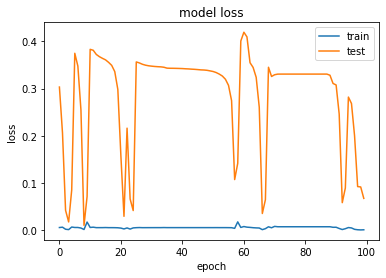

In [20]:
model=model_lstm(window+1,6)
history=model.fit(X_trainw,y_trainw,epochs=100, batch_size=30, validation_data=(X_testw, y_testw), \
                  verbose=1, callbacks=[],shuffle=False) # Batch size should be no more than the square root of the # of training rows

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [21]:
y_pr=model.predict(X_trainw)

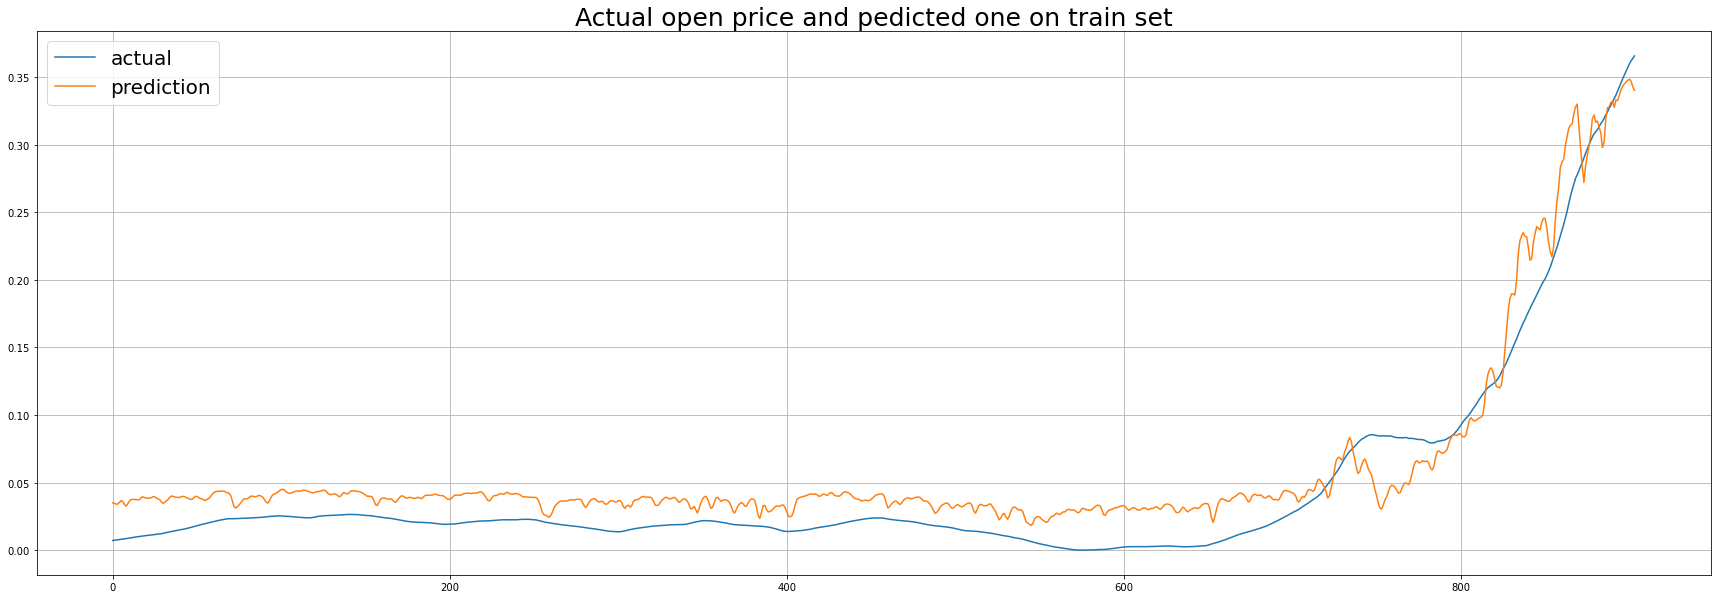

In [22]:
plt.figure(figsize=(30,10))
plt.plot(y_trainw, label="actual")
plt.plot(y_pr, label="prediction")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price and pedicted one on train set",fontsize=25)
plt.show()

In [23]:
y_pred=model.predict(X_testw)

In [24]:
v=np.diff(y_pred.reshape(y_pred.shape[0]),1)
v_lstm=np.maximum(np.sign(v),0)

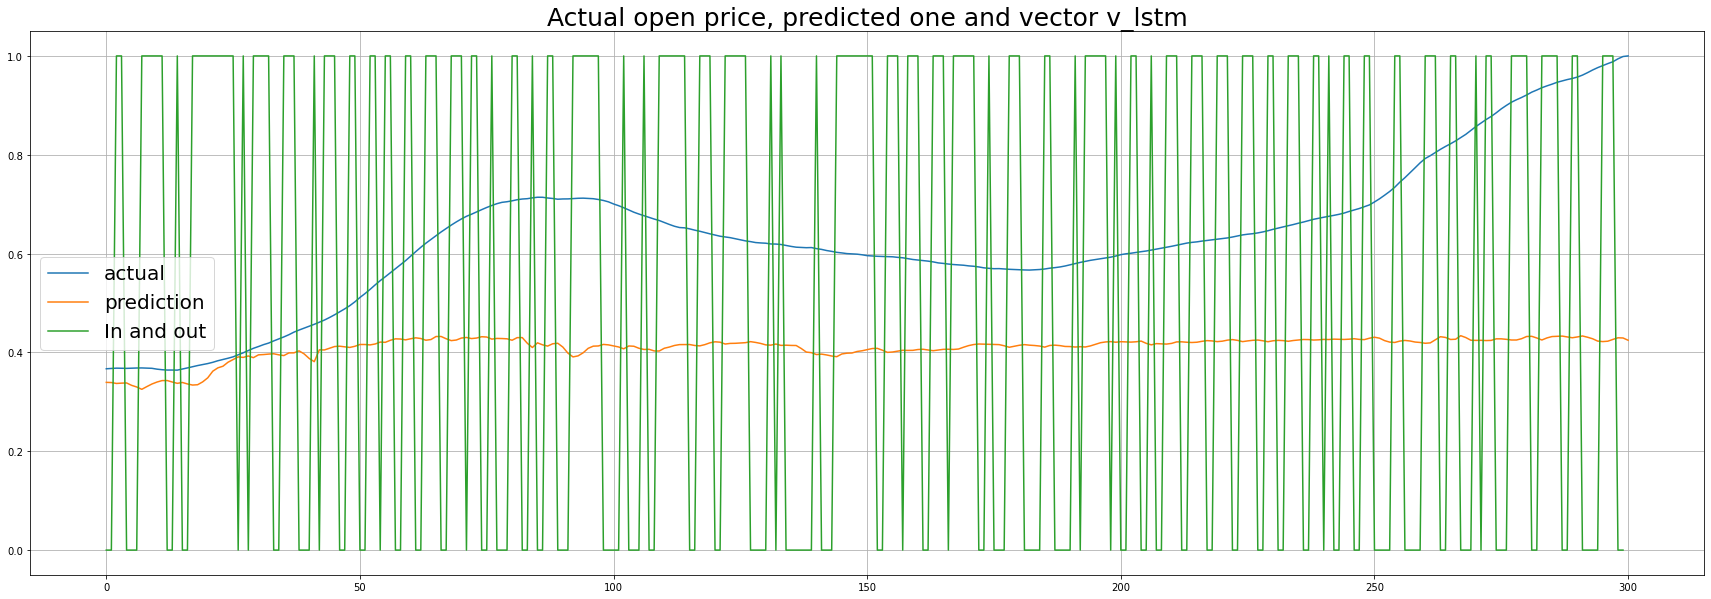

In [25]:
plt.figure(figsize=(30,10))
plt.plot(y_testw, label="actual")
plt.plot(y_pred, label="prediction")
plt.plot(v_lstm,label="In and out")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price, predicted one and vector v_lstm",fontsize=25)
plt.show()

Part 4: Compare the LSTM method with other methods
Now we can copare our LSTM-trading-strategy with the buy and hold strategy and the moving average strategy. In order to do so we compute the corresponding vectors v_bh and v_ma which select the days during which we are going to stay in the market.

In [26]:
v_bh=np.ones(test.shape[0])
v_ma=test["Open"]>test["mv_avg_short"]
v_ma_l=test["Open"]>test["mv_avg_long"]

In [27]:
def gross_portfolio(df,w):
    portfolio=[ (w*df["rapp"]+(1-w))[:i].prod() for i in range(len(w))]
    return portfolio

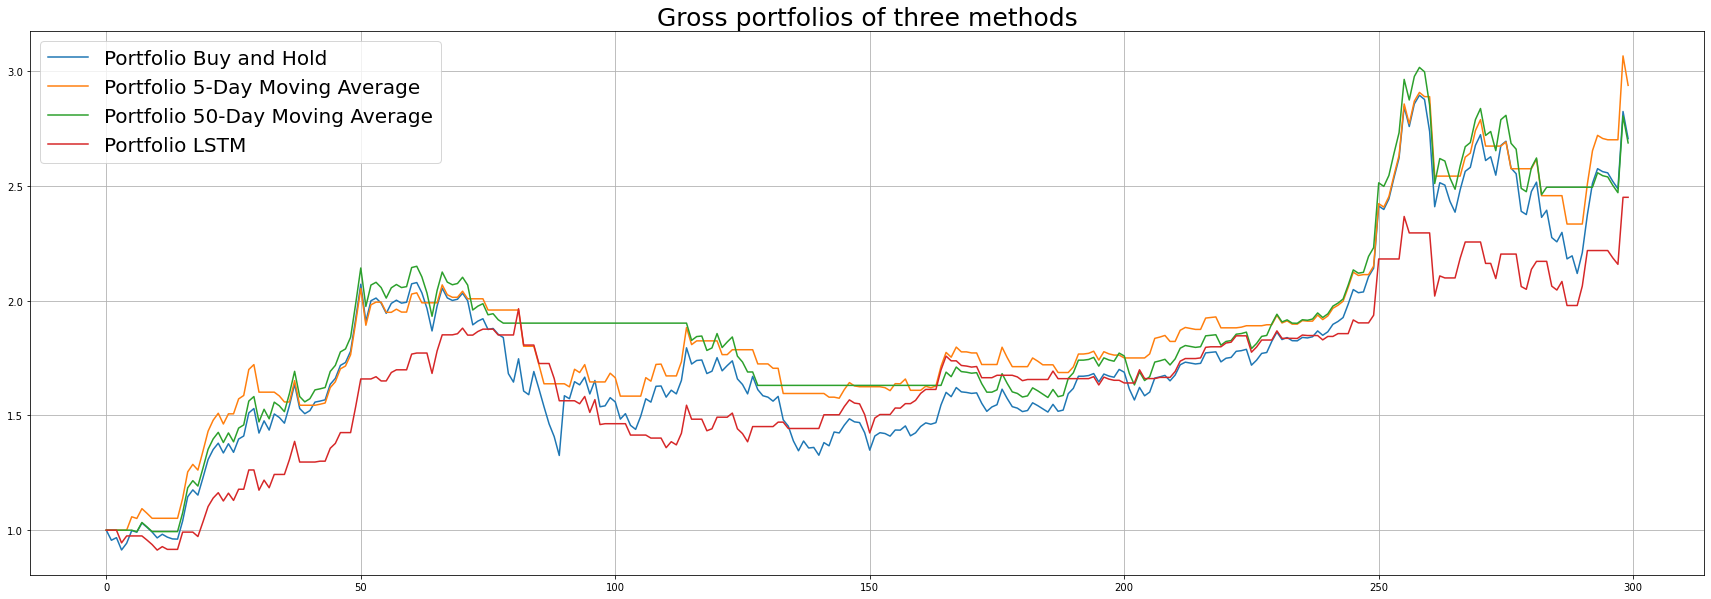

In [28]:
plt.figure(figsize=(30,10))
plt.plot(gross_portfolio(test,v_bh),label="Portfolio Buy and Hold")
plt.plot(gross_portfolio(test,v_ma),label="Portfolio 5-Day Moving Average")
plt.plot(gross_portfolio(test,v_ma_l),label="Portfolio 50-Day Moving Average")
plt.plot(gross_portfolio(test,v_lstm),label="Portfolio LSTM")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Gross portfolios of three methods", fontsize=25)
plt.show()

In [29]:
print("Test period of {:.2f} years, from {} to {} \n".format(len(v_bh)/365,str(test.loc[test.index[0],"Open"])[:10],\
      str(test.loc[test.index[-1],"Close"])[:10]))

results0=pd.DataFrame({})
results1=pd.DataFrame({})

# results0["Method"]=["Buy and hold","Moving average","LSTM"]
# results1["Method"]=["Buy and hold","Moving average","LSTM"]

results0["Method"]=["Buy and hold","5-Day Moving average","50-Day Moving average","LSTM"]
results1["Method"]=["Buy and hold","5-Day Moving average","50-Day Moving average","LSTM"]

vs=[v_bh,v_ma,v_ma_l,v_lstm]
results0["Total gross yield"]=[str(round(yield_gross(test,vi)[0],2))+" %" for vi in vs]
results1["Annual gross yield"]=[str(round(yield_gross(test,vi)[1],2))+" %" for vi in vs]

print(results0)
print("\n")
print(results1)

Test period of 0.82 years, from 416.480010 to 1088.11999 

                  Method Total gross yield
0           Buy and hold          156.22 %
1   5-Day Moving average          178.21 %
2  50-Day Moving average          154.46 %
3                   LSTM          145.11 %


                  Method Annual gross yield
0           Buy and hold           120.41 %
1   5-Day Moving average           136.19 %
2  50-Day Moving average           119.14 %
3                   LSTM           112.36 %
